# Lab 4: Kalman Filtering and Online Bayesian Inference

### Lab Date: Wednesday, February 19

### Parts II and III Due: Wednesday, February 26

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in lab next week (Wednesday, February 26th). This is the second half of the lab you started last week. To access the first half, click this link: [Lab 3](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fberkeley-stat238%2Fspring-2025&urlpath=tree%2Fspring-2025%2Flabs%2Flab03%2FLab_3.ipynb&branch=main)

In this lab, you will:

1. *Practice with our next family of conjugate models: the normal-normal model, [Part I]*
1. See how easily (some) conjugate models extend to thorny multi-dimensional problems, and thus, why they are so popular as building blocks for large problems, [Part I and II]
1. See how the self-consistency of Bayesian inference allows for straightforward on-line inference (inference as the data is collected). [Parts II and III]

Together, these demonstrate two of the common selling points for Bayesian methods: (1) they extend easily and consistently to multiple dimensions without requiring the user to make arbitrary choices to reduce dimension (e.g. picking a test statistic), (2) they are very natural to work with when tracking sequential data. It also demonstrates a subtler computational message. The larger our problems, the more useful analytic results are. As you read ahead, try to imagine what the procedure would look like if we replaced the simple algebra that follows from conjugacy with sampling, or, god forbid, numerical integration.

These learning goals will be presented to you through the Kalman filter, a fundamental tool for data assimilation in dynamical systems. The Kalman filter is an iterated application of a Gaussian likelihood, a Gaussian prior on the mean, and a linear update model to represent a dynamical system with a measurement protocol. Until this year, this approach was state-of-the-art for very large online prediction problems such as weather forecasting (see [GraphCast, 2023](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) and [GenCast, Nature, 2025](https://www.nature.com/articles/s41586-024-08252-9)).

The Kalman filter involves *a lot* of algebra. We've scaffolded that algebra, and the associated inferential code, for you. Focus on the statistical story represented in the algebra. 

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6192475) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [2]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import scipy as scipy
from scipy import linalg
import matplotlib.pyplot as plt

## [PART I - Reference] Conjugate Gaussian Models

This lab builds directly on the machinery you built in Lab 3. To access Lab 3 click this link: [Lab 3](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fberkeley-stat238%2Fspring-2025&urlpath=tree%2Fspring-2025%2Flabs%2Flab03%2FLab_3.ipynb&branch=main).

You are welcome to copy other components of your group's work on lab 3 here as reference.


## [PART II] Kalman Filters

Consider the following problem:

You are a meteorologist insterested in predicting the weather. You have access to a large, varied, set of real-time data sources. These provide a constant stream of measurements. Even so, the real weather system is unimaginably high-dimensional. So, even with input from satellites, and weather stations, and weather bouys, and balloon launches, and everything else NOA attempts, we are still far from omniscient. Given your data, the true state of the weather at any time is unknown.

Worse still, the weather is constantly changing. 

These two ingredients pose a data assimilation problem. In data assimilation, we make measurements in real time of an unknown, *potentially changing*, quantity, usually called the state vector. Unlike the examples we've considered before, asymptotic consistency guarantees don't apply since the unknown is constantly moving. Our aim is to keep ``assimilating" new data into a model for the motion of the unknown in order to keep a good guess at the range of possible states given the observed sequence of measurements. In other words, we want to sequentially update a posterior after each measurement.

Data assimilation has two key components:
1. A dynamical systems model that specifies how we would expect the state vector to change over time if we knew it's exact initial conditions at some point in time. This system may be deterministic, or stochastic. In the weather analogy, this is a massive PDE simulator, built on a combination of fundamental physics (i.e. Navier-Stokes) and geochemistry (water cycles, etc.). In all that follows the true, but unknown, state of the system will be represented as $x(t)$ (if in continuous time), or $x_t$ in discrete time. We will treat this as random quantity, but use lower case letters to maintain a clear distinction between matrices and vectors.
1. A statistical model that specifies a prior distribution over the unknowns before any measurement, and an error model relating the true state of the system to the observed measurements. In all that follows we will let $y_t$ represent the measurements made at time $t$. Typically, $y_t$ is a low dimensional object relative to $x_t$. Hence, we are in the standard "small sample" regime of Bayesian statistics where we aim to repeatedly solve an ill-posed problem.

Given a model, we update a posterior distribution after each new measurement, using the posterior after the previous measurement as our prior, and using the dynamical systems model and measurement model to specify the likelihood.

A Kalman filter linearizes the dynamical system and measurement model (assumes small time steps and concentrated posteriors), and uses a (Normal, Normal) conjugate model. In this setting, the posterior over the unknown state remains Gaussian at all times. Since a Gaussian is fully specified by its mean and covariance, applying data assimilation reduces to running an algebraic recursion driven by a constant stream of input measurements.

### An overview.

The idea in a Kalman filter is to continuously update a Gaussian approximation to the posterior distribution of the unknown state given a series of sequential measurements. In what follows, let $x_t$ denote the (unknown) state at time $t$, and $y_t$ denote the corresponding observation. Between each observations, $x_t$ is updated by a noisy dynamical system. As long as the time step is small, the mapping imposed by the system is approximately linear. Similarly, as long as we can collect enough measurements to keep the posterior concentrated, then the action of any, potentially nonlinear, set of measurement functions, are approximately linear. Then, every update is either, a linear transformation plus Gaussian noise, or a posterior inference step based on a linear measurement. Each of these steps preserve the family of Gaussian distributions, so the entire pipeline can be represented by deriving a recursion on the mean and covariance of the state vector $\{\hat{x}_t,P_t\}_{t=1}^{...}$. Since we will condition on all past observations to constrain our inference, we will write, $\hat{x}_{t|t-1},P_{t|t-1}$ to denote the posterior mean and covariance over the state vector after measurement $y_t$. 

Then, after initializing with a Gaussian prior mean $\hat{x}_0$ and covariance $P_0$, we will run a recursive process of the form:

1. Push the posterior distribution left after the observation at time $t$ forward to a prior for time $t+1$ by running the dynamics (apply the linear update equation you derived in Lab 3 [PART I] Q 1.7).
1. Make an observation, $y_{t}$
1. Condition on the observation, using the new prior, to derive a new posterior via Lab 3 [PART I] equation (1).
1. Iterate.

All of the algebra below is just a clever implementation of this idea.



### Example: Simple Harmonic Oscillators

A simple harmonic oscillator obeys the dynamical system: 

\begin{equation}
\frac{d^2 x}{d t^2} + \omega^2 x =0
\end{equation}

This is an interesting first test case since it is, in a sense, as about as easy a dynamic to track as possible without resorting to convergent models that stop changing after some time. 

Harmonic oscillators are an example of a special class of dynamical systems called Hamiltonian systems. These have the remarkable property that they conserve volume. That is, if you initialize the dynamical system with an infinite collection of initial conditions on the boundary of some closed region, then the volume enclosed as the boundary evolves forward under the dynamic will remain the same. Systems with this property preserve the entropy of any continuous distribution of states evolving under the dynamic. We'll see why this is useful in a moment.

### Step 1: Define the State-Space Model
A state-space model consists of a system equation and a measurement equation. The system equation describes how the true state evolves over time, while the measurement equation describes how observations are obtained. 

The system equation is given by:
$$ x_{t+1} = A_t x_t + w_t $$
where $x_t$ is the state vector at time $t$, $A_t$ is the transition matrix, and $w_t$ is process noise, assumed to be Gaussian with covariance $Q$. Note that $A_t$ could depend on time. This happens for nonlinear dynamics. Then, it is standard to set $A_t$ to the Jacobian of the dynamical system evaluated at $\hat{x}_t$. 

If the dynamical system is Hamiltonian, then the mapping $A_t$ must also be volume preserving. It follows that $A_t$ is a *unitary* transformation. This means that, in a sense, multiplying by $A_t$ will preserve the covariance of the posterior distribution. In particular, the determinant of the covariance of a random vector is preserved, so the transformation preserves the geometric mean of the principal variances (eigenvalues of the covariance). This means that, in a sense, under the dynamic alone, the distribution of possible state vectors will not spread out too quickly. However, it does not guarantee that the dynamic will not stretch or compress the distribution along a particular direction. It only guarantees that the geometric average of the stretching and compression factors balance out to 1.


The measurement equation is given by:
$$ y_t = H_t x_t + v_t $$
where $y_t$ is the observed measurement, $H_t$ is the observation matrix, and $v_t$ is measurement noise, assumed to be Gaussian with covariance $R$. As before, the measurement matrix could, in principle, change in time if we are linearizing a nonlinear measurement function. For now, we will assume $H_t$ is fixed.

In [3]:
# Define the state-space model
dt = 0.1  # Time step
omega = 1.0  # Natural frequency
A_euler = np.array([[0, dt], [-omega**2 * dt, 0]])  # State transition matrix using forward Euler
A = scipy.linalg.expm(A_euler)
H = np.array([[1, 0]])  # Measurement matrix
Q = np.eye(2) * 0.005 * dt  # Process noise covariance
R = np.eye(1) * 0.5  # Measurement noise covariance

# Initialize state estimate and covariance
x_est = np.array([[1], [0]])  # Initial position and velocity
P = np.eye(2) * 1.0  # Initial uncertainty

# Simulate noisy measurements
periods = 6
time_steps = round(periods*2*np.pi/dt)
true_states = []
measurements = []
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())

### Step 2: Compute the Prediction Step
At each time step, we predict the next state using the system dynamics.


1. **State Prediction:** Set:
   $$ \hat{x}_{t|t-1} = A \hat{x}_{t-1|t-1} $$
   This equation propagates the previous estimate through the state model to predict the next state.

2. **Covariance Prediction:**
   $$ P_{t|t-1} = A P_{t-1|t-2} A^T + Q $$
   Here, we compute the predicted covariance, which accounts for the uncertainty in the process model.


### Step 3: Compute the Kalman Gain
The Kalman gain determines how much weight is given to the new measurements:

$$ K_t = P_{t|t-1} H^T (H P_{t|t-1} H^T + R)^{-1} $$

This equation balances trust in the prediction versus the new observation.

### Step 4: Compute the Update Step
When a new measurement $y_t$ is available, we update our state estimate:

1. **State Update:**
   $$ x_{t|t} = \hat{x}_{t|t-1} + K_t (y_t - H \hat{x}_{t|t-1}) $$
   This correction ensures that the estimate accounts for the measurement innovation.

2. **Covariance Update:**
   $$ P_{t|t} = (I - K_t H) P_{t|t-1} $$
   Updating the covariance reduces uncertainty after incorporating the new measurement.

### Step 5: Implement the Kalman Filter
Now that we have derived the equations, we implement the Kalman Filter iteratively over multiple time steps. At each step, we:
1. Use the state transition model to predict the next state.
2. Compute the Kalman Gain to determine the weight of the new measurement.
3. Update the state estimate based on the new measurement.
4. Update the covariance to reflect new uncertainty levels.
5. Repeat for all incoming measurements.

In [4]:
# Implement the Kalman Filter
filtered_states = []
for z in measurements:
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q
    
    # Compute Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    
    # Update Step
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(2) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

### Step 6: Visualizing the Results
To understand how well the Kalman Filter performs, we plot the following elements:
1. **True State**: The actual underlying system state.
2. **Filtered State**: The estimated state obtained from the Kalman Filter.
3. **Measurements**: The noisy observations received over time.

The plot helps visualize how closely the Kalman Filter is able to track the true state despite noisy measurements. We expect the filtered state to be smoother than the measurements and follow the trend of the true state closely.

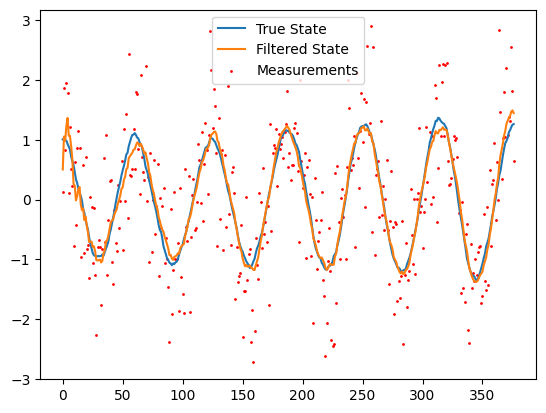

In [5]:
# Plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in filtered_states], label='Filtered State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
plt.legend()
plt.show()

## Experiments To Run

Using the code provided above, run the following experiments:

**Q 2.1:** Set the process noise to `0.005 * dt`, the measurement noise to `0.5`, and the time step `dt` to `0.05`. Run the Kalman filter a couple times to get a sense for its general behavior. Save a representative output plot below. 

Comment on how many cycles it takes before the filtered state approximation appears to converge, how smooth the filtered sequence of states are (how reactive are they to new measurements), and the accuracy of the predicted state. Do the errors between the true and filtered state decrease over time? Does it vanish?

Answer: While the scale of the errors does seem to decrease, at least immediately from the beginning, there is nonetheless usually some error near the peaks and troughs of the true state, which doesn't seem to decrease with time.


In [6]:
def generate_measurements(dt=0.1, omega=1.0, Q=np.eye(2) * 0.005 * dt, R=np.eye(1) * 0.5, periods=14):
    # Define the state-space model
    A_euler = np.array([[0, dt], [-omega**2 * dt, 0]])  # State transition matrix using forward Euler
    A = scipy.linalg.expm(A_euler)
    H = np.array([[1, 0]])  # Measurement matrix

    # Initialize state estimate and covariance
    x_est = np.array([[1], [0]])  # Initial position and velocity
    P = np.eye(2) * 1.0  # Initial uncertainty

    # Simulate noisy measurements
#     periods = 6
    time_steps = round(periods*2*np.pi/dt)
    true_states = []
    measurements = []
    for _ in range(time_steps):
        x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
        measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
        true_states.append(x_est.flatten())
        measurements.append(measurement.flatten())

    # Implement the Kalman Filter
    filtered_states = []
    for z in measurements:
        # Prediction Step
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        # Compute Kalman Gain
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)

        # Update Step
        x_est = x_pred + K @ (z - H @ x_pred)
        P = (np.eye(2) - K @ H) @ P_pred

        filtered_states.append(x_est.flatten())
    
    plt.plot([s[0] for s in true_states], label='True State')
    plt.plot([s[0] for s in filtered_states], label='Filtered State')
    plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=1)
    plt.legend()
    plt.show()
    
    return np.mean([(true_states[i][0] - filtered_states[i][0]) ** 2 for i in range(len(true_states))])

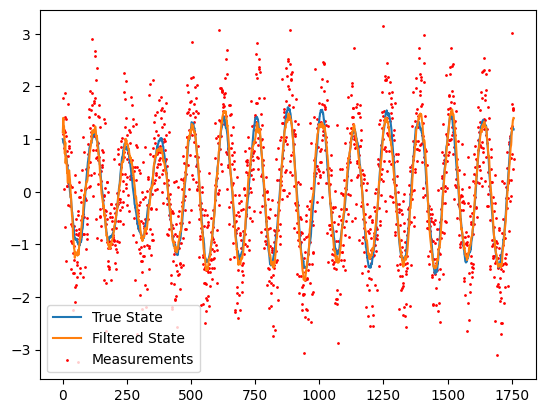

0.018627648298112934

In [7]:
# Insert demo for Q 2.1 here...

generate_measurements(dt=0.05)

**Q 2.2:** Let's try to understand the role of the process noise. Try:
1. Setting the process noise to zero
1. Setting the process noise large (large enough to see distinctly new behavior)

In each case, comment on whether the filtered values converge to the true state. Comment on whether this is even possible, and if so, how the filter manages to collect enough information to converge. Think carefully about: 
- The structure of this dynamical system (e.g. is it linear?).
- Is convergence equivalent to resolving the exact state of the process at any specific point in time (i.e. use the full data stream to resolve the initial condition)? 

Comment on how the smoothness of the filtered process changes as the process noise changes. Why should the process noise influence the smoothness of the estimated state?

Answer: As the process noise increases, the smoothness of the true state decreases, as does the smoothness of the estimated state. Both the true and estimated curves become very jagged, with marked differences in true and predicted values.

It makes sense that the process noise influences the estimated state, because it directly influences the true state.

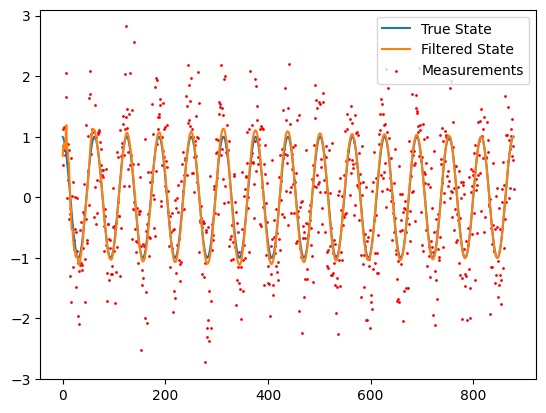

0.004071148366086895


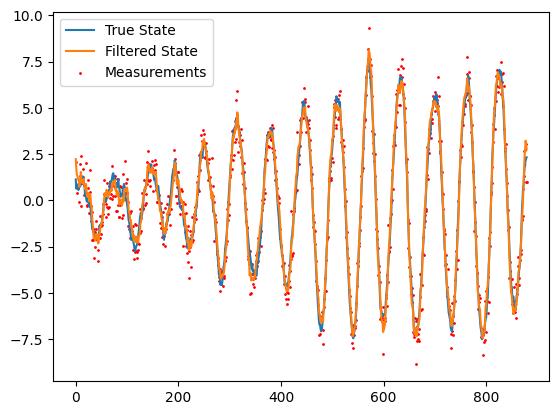

0.14559829480804298


In [8]:
# Insert demo for Q 2.2 here...
print(generate_measurements(Q=np.eye(2) * 0 * dt))

print(generate_measurements(Q=np.eye(2) * 0.3 * dt))

**Q 2.3:** Return the process noise to `0.005 * dt`. Now, let's try to understand the role of the measurement noise. As before, try:

1. Setting the measurement noise to zero
2. Setting the measurement noise large (try setting it to `10`, or `25`, or `100`).

Comment on the accuracy of the filtered state as an estimate for the true state. Note whether it converges to a smooth process, whether it converges near the truth, and on the accuracy of the recovery relative to the signal-to-noise ratio in each individual measurement. Are you surprised by the amount of measurement noise we can tolerate? How is it possible to retain high accuracy estimates with such high measurement noise?

Even though there are some discrepancies between predicted and true state, even with very high measurement noise, we are still nonetheless able to maintain relatively high accuracy. This does come as a surprise, but I think this can also make sense in that our past estimates help stabilize and are a good source of information for the current estimates, which helps offset the measurement noise of the current estimate significantly.

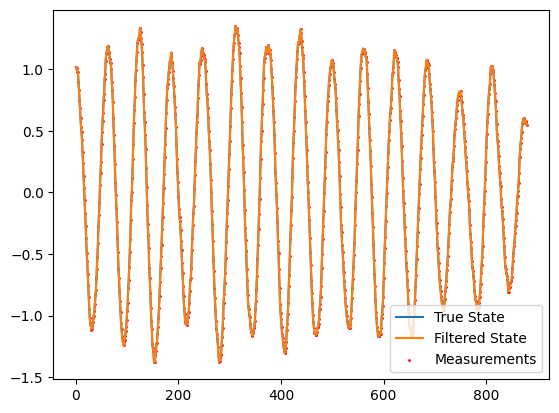

1.2738084238001515e-37


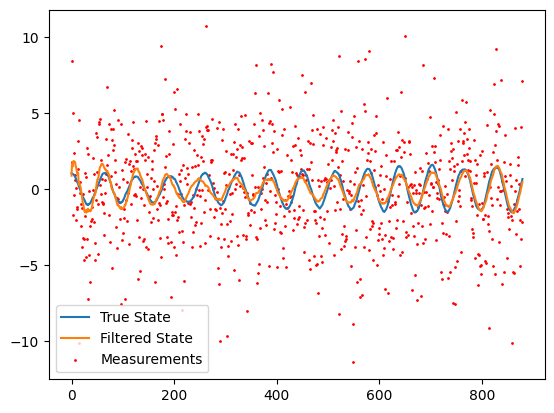

0.15110546953183224


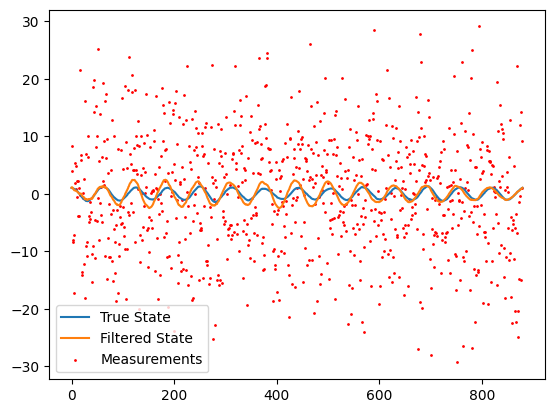

0.5524126936818508


In [9]:
# Insert demo for Q 2.3 here...

print(generate_measurements(R = np.eye(1) * 0))

print(generate_measurements(R = np.eye(1) * 10))

print(generate_measurements(R = np.eye(1) * 100))

**Q 2.4:** We've seen the filter work. Now, let's break it.

1. Try setting the process noise to `0.1 * dt` and the measurement noise to `10`. Compare the accuracy and smoothness of the reconstruction to your results with measurement noise `10` in Q 2.4. Decrease the measurement noise until the process converges (holding the process noise fixed). Why is the threshold on acceptable measurement noise controlled by the process noise?

Answer: The process noise can be thought of as being inversely related to how similar the current state is to the state at the previous time step. Since this similarity is used to supplement our estimates and make up for bad measurement noise, it makes sense that as process noise decreases, our tolerance for measurement noise will also decrease.

2. Set the process noise and measurement noise back to their defaults (`0.005 * dt` and `0.5`). Try increasing the sample interval to `0.5` and increase the total simulation time from `6` periods to `12`. Is the process capable of converging for sparse time sampling? If not, try decreasing either the process noise or the measurement noise until the process converges. Which controls the possibility of convergence? Why?

Answer: We find that we are able to converge even with a higher total simulation time.

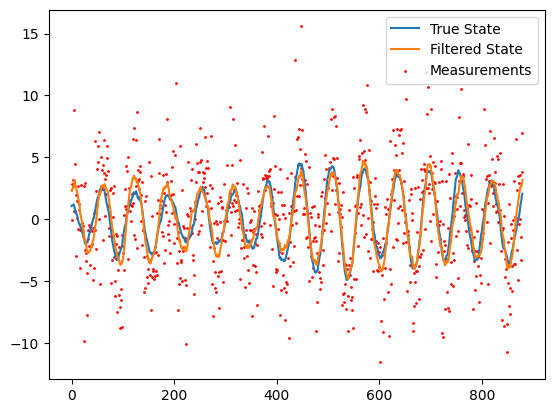

0.596220385588806


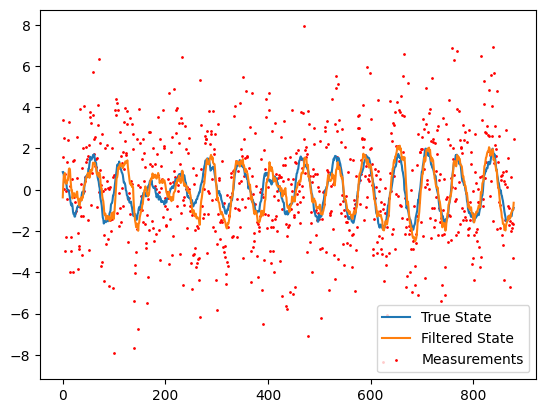

0.2764717124820058


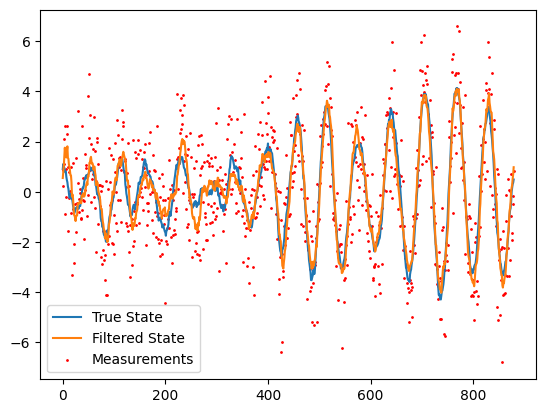

0.18287002257043936


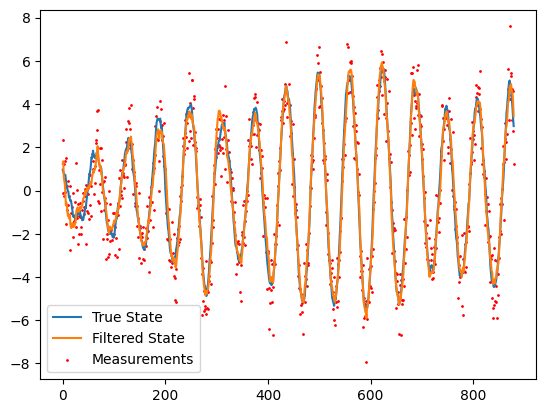

0.15547081559042888


In [10]:
# Insert demo for Q 2.4 here...
print(generate_measurements(Q=np.eye(2) * 0.1 * dt, R = np.eye(1) * 10))
print(generate_measurements(Q=np.eye(2) * 0.1 * dt, R = np.eye(1) * 5))
print(generate_measurements(Q=np.eye(2) * 0.1 * dt, R = np.eye(1) * 2))
print(generate_measurements(Q=np.eye(2) * 0.1 * dt, R = np.eye(1) * 1))

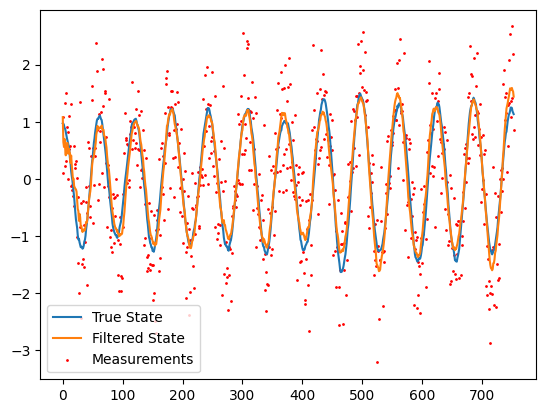

0.03388074602174119


In [11]:
dt = 0.5
print(generate_measurements(periods=12))

**Q 2.5:** Comment on the overall success of the Kalman filter as an inferential tool. Consider the dimensionality of the object we are estimating, the dimensionality of our measurements, and the filter's capacity to integrate both past information while adapting to new observations. 

Overall, we think that the Kalman filter is excellent in this use case, as it provides convergence with little to no deviations from the truth under favorable conditions, and it has been very robust to errors.

## [PART III] Application: Lorenz System Equations
The Lorenz system is a set of three differential equations used to model chaotic behavior:

$$
\frac{dx}{dt} = \sigma (y - x), \quad \frac{dy}{dt} = x (\rho - z) - y, \quad \frac{dz}{dt} = xy - \beta z
$$

where $\sigma$, $\rho$, and $\beta$ are system parameters that control the chaotic behavior of the system. These equations describe the evolution of three state variables $x, y, z$ over time. This system was first derived as an extremely simplified weather model based. It is famous as the dynamical systems model which led to the discovery of chaotic dynamical systems.

The Lorenz system is an interesting contrast to the harmonic oscillator example. First, it's dynamic is nonlinear, so the entire collection of process and measurement values are not jointly Gaussian distributed. This means that, the Kalman filter only performs *approximate* posterior inference for the Lorenz model. 

Second, unlike the harmonic oscillator example, the Lorenz system is chaotic. This means that, given long enough, any pair of state vectors initialized from the same location will spread arbitrarily far apart, and mix over some attractor. For the Lorenz system, this attractor is the eponymous "butterfly" of the butterfly effect. Accurate weather prediction beyond ten days remains an unsolved scientific problem in large part because weather systems are chaotic.

Chaotic systems present the hardest possible case for data assimilation. In a chaotic system, we are constantly using measurement to tamp down the ever expanding uncertainty produced by the dynamic. Chaos is also typical for real systems where data assimilation is used. 

### Discretize the System
Since the Kalman filter operates in discrete time, we need to approximate the continuous Lorenz equations using a numerical method. We use the Runge-Kutta method to integrate the system over small time steps, ensuring accuracy in tracking the chaotic dynamics.

### Step 1: Generate Noisy Observations
In real-world applications, measurements are subject to noise. We assume that only the \( x \) and \( y \) components are observable and introduce Gaussian noise to simulate sensor inaccuracies:

$$ y_t = H x_t + v_t $$

where \( v_t \) is Gaussian measurement noise with covariance \( R \).

In [12]:
from scipy.integrate import solve_ivp

# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
dt = 0.02  # Time step - default 0.02

# Define the Lorenz system
def lorenz_system(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Solve Lorenz system numerically
t_end = 20
time_span = np.linspace(0, t_end, round(t_end/dt))
sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], [1, 1, 1], t_eval=time_span)

# Observation matrix (assume we only observe x and y)
H = np.array([[1, 0, 0], [0, 1, 0]])
Q = np.eye(3) * 0.0 * dt  # Process noise covariance - Set very small since we solved the dynamic exactly above. Any noise here models integration error in the ODE solver
R = np.eye(2) * 0.2  # Measurement noise covariance - default 0.2

# Initial state and covariance
x_est = np.array([[1], [1], [1]])
P = np.eye(3) * 1.0

# Generate noisy observations
measurements = sol.y[:2].T + np.random.normal(0, 1, (len(time_span), 2)) @ scipy.linalg.sqrtm(R).T

### Step 2: Compute the Prediction Step
At each time step, we predict the next state using the system dynamics.

Since the Lorenz system is nonlinear, we will have to derive the state transition matrix $A(\hat{x}_t)$ to approximately linearize the dynamic over the range of possible states. (Note: if the time steps are too large, it is common to replace this linear, approximate, update, with explicit simulation of a collection of states sampled from the current posterior. These may be simulated forward, then fit to a Gaussian, to give a new Gaussian prior, which is used to infer a new posterior after measurement).

For now, we will proceed by linearizing explicitly. To linearize, first compute the Jacobian of the dynamic:
$$
   J([x,y,z]) = [\partial_x, \partial_y, \partial_z] \left[\begin{array}{c} \sigma (y - x) \\ x (\rho - z) - y \\ x y - \beta z \end{array} \right] = \left[ \begin{array}{ccc} - \sigma & \sigma & 0 \\ \rho & -1 & -x \\ y & x & - \beta \end{array} \right]. 
$$
Then, set:
$$
A(\hat{x}_t) = \exp(J(\hat{x}_t) \Delta t)
$$
where $\Delta t$ is the length of the time step, and $\exp(\cdot)$ is the matrix exponential.

Now that we've linearized the action of the dynamic over a time step, we can proceed as before. Think carefully about what assumptions on the state covariance, and the length of the time step, are needed to ensure this approximation is reliable.

1. **State Prediction:** Set $A_t = A(\hat{x}_{t-1|t-1})$. Then, set:
   $$ \hat{x}_{t|t-1} = A_t \hat{x}_{t-1|t-1} $$
   This equation propagates the previous estimate through the state model to predict the next state.

2. **Covariance Prediction:**
   $$ P_{t|t-1} = A_t P_{t-1|t-1} A_t^T + Q $$
   Here, we compute the predicted covariance, which accounts for the uncertainty in the process model.

### Step 3: Compute the Kalman Gain
Proceed as before. 
### Step 4: Compute the Update Step
Proceed as before. 

In [13]:
# Kalman filter implementation
filtered_states = []
for z in measurements:
    J = np.array([[-sigma, sigma, 0], 
                  [rho, -1, -x_est[0]], 
                  [x_est[1], x_est[0], -beta]],
                dtype=object)  # Jacobian of the Lorenz dynamic
    A = scipy.linalg.expm(J * dt) # state transition matrix for linear approximation to the dynamic
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q

    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est = x_pred + K @ (z.reshape(-1, 1) - H @ x_pred)
    P = (np.eye(3) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

filtered_states = np.array(filtered_states)

### Step 5: Implement the Kalman Filter and Visualize Results
To evaluate the filter’s performance, we plot:
1. **True State**: The numerically integrated Lorenz system.
2. **Filtered State**: The Kalman filter’s best estimate.
3. **Measurements**: The noisy observations.

This visualization helps assess how well the Kalman filter mitigates chaos-induced divergence.

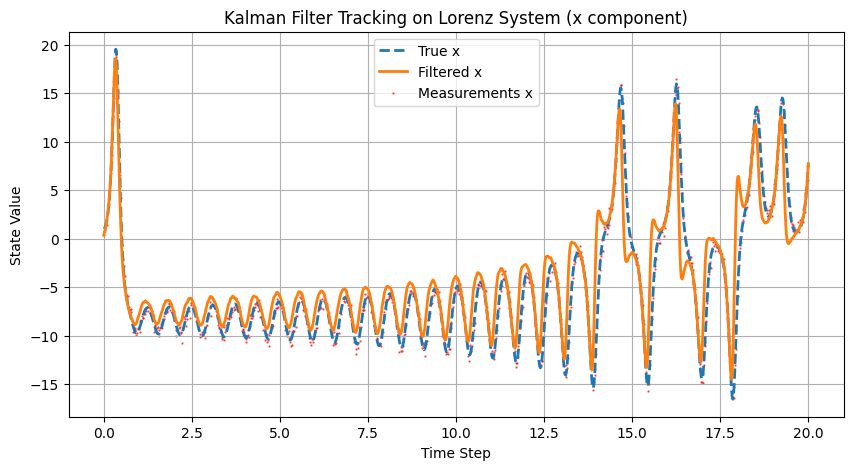

In [14]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(time_span, sol.y[0], label='True x', linestyle='dashed', linewidth=2)
plt.plot(time_span, filtered_states[:, 0], label='Filtered x', linewidth=2)
plt.scatter(time_span, measurements[:, 0], label='Measurements x', color='red', s=0.5, alpha=0.6)
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter Tracking on Lorenz System (x component)')
plt.legend()
plt.grid(True)
plt.show()

**Q 3.1:** Try increasing the process noise. In particular, try setting the process noise to `0.01 * dt` and the measurement noise to `0.2`. Compare to the results you get when the process noise is zero.

Note that, in this case, we simulated the dynamic deterministically. If you increase the process noise, you are, in effect, performing posterior inference using a softened likelihood model, that assumes more noise in the process, and thus looser temporal coupling, than there is true noise in the process. This is, in effect, using a less informative prior model at each time step. Comment on how this changes the behavior of the filtered estimate when the measurement noise is small. Do you think that adopting a weaker prior is helpful in this case?

We find that, counterintuitively, an increased process noise has corresponded to a stronger convergence. We're not sure why this is, though maybe it is because our prior as it is is too strong.

In [15]:
dt = 0.02

def kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.2):
    # Lorenz system parameters
    sigma, rho, beta = 10, 28, 8/3

    # Define the Lorenz system
    def lorenz_system(t, state):
        x, y, z = state
        dxdt = sigma * (y - x)
        dydt = x * (rho - z) - y
        dzdt = x * y - beta * z
        return [dxdt, dydt, dzdt]

    # Solve Lorenz system numerically
    t_end = 20
    time_span = np.linspace(0, t_end, round(t_end/dt))
    sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], [1, 1, 1], t_eval=time_span)

    # Observation matrix (assume we only observe x and y)
    H = np.array([[1, 0, 0], [0, 1, 0]])

    # Initial state and covariance
    x_est = np.array([[1], [1], [1]])
    P = np.eye(3) * 1.0

    # Generate noisy observations
    measurements = sol.y[:2].T + np.random.normal(0, 1, (len(time_span), 2)) @ scipy.linalg.sqrtm(R).T
    
    # Kalman filter implementation
    filtered_states = []
    for z in measurements:
        J = np.array([[-sigma, sigma, 0], 
                      [rho, -1, -x_est[0]], 
                      [x_est[1], x_est[0], -beta]],
                    dtype=object)  # Jacobian of the Lorenz dynamic
        A = scipy.linalg.expm(J * dt) # state transition matrix for linear approximation to the dynamic
        x_pred = A @ x_est
        P_pred = A @ P @ A.T + Q

        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
        x_est = x_pred + K @ (z.reshape(-1, 1) - H @ x_pred)
        P = (np.eye(3) - K @ H) @ P_pred

        filtered_states.append(x_est.flatten())

    filtered_states = np.array(filtered_states)
#     print(len(filtered_states), len(true_states))
    
    # Visualization
    plt.figure(figsize=(10, 5))
    plt.plot(time_span, sol.y[0], label='True x', linestyle='dashed', linewidth=2)
    plt.plot(time_span, filtered_states[:, 0], label='Filtered x', linewidth=2)
    plt.scatter(time_span, measurements[:, 0], label='Measurements x', color='red', s=0.5, alpha=0.6)
    plt.xlabel('Time Step')
    plt.ylabel('State Value')
    plt.title('Kalman Filter Tracking on Lorenz System (x component)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
#     return np.mean([(true_states[i][0] - filtered_states[i][0]) ** 2 for i in range(len(true_states))])

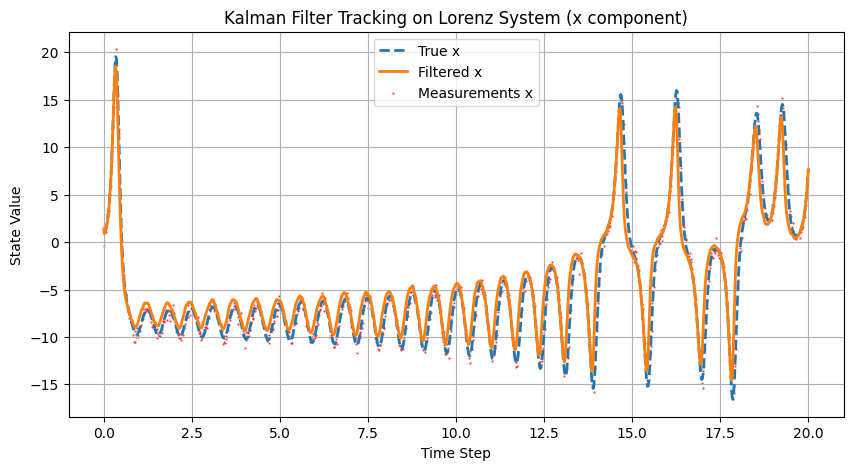

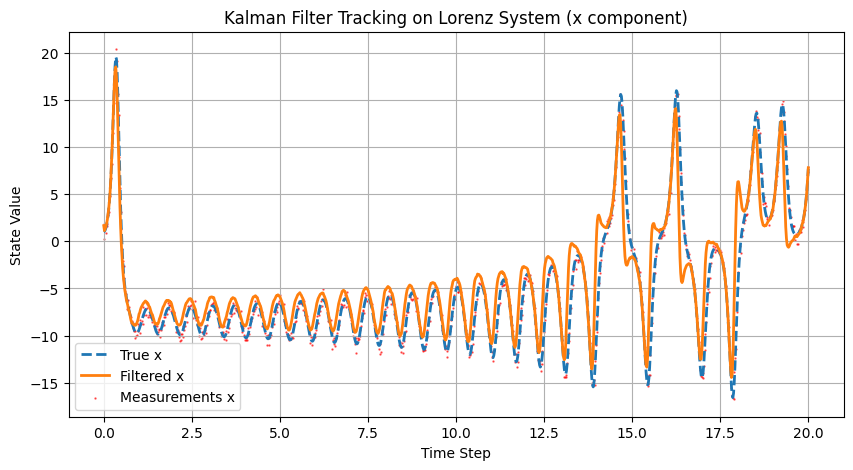

In [16]:
# Insert experiments for Q 3.1 here...
kalman_2(Q=np.eye(3) * 0.01 * dt, R = np.eye(2) * 0.2)
kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.2)

**Q 3.2:** Set the process noise back to zero. Try gradually decreasing the measurement noise level. Can you find a nonzero measurement noise level small enough such that the filtered process converges over the full range of simulated time steps? Compare to the results you observed for the simple harmonic oscillator with no process noise. Try to explain the phenomena you observe.

We are not able to converge over the full range of time steps for any measurement noise level.

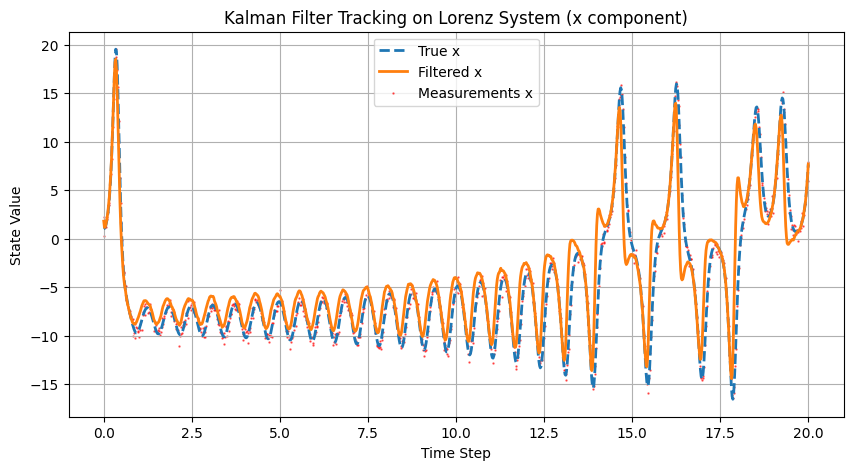

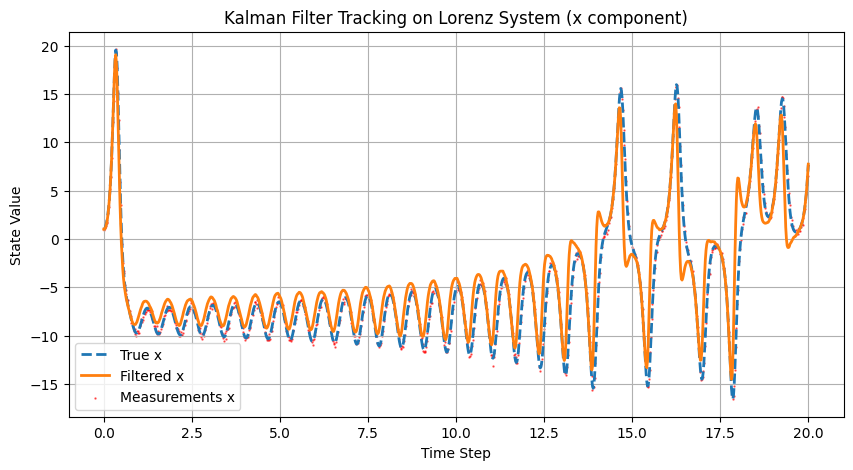

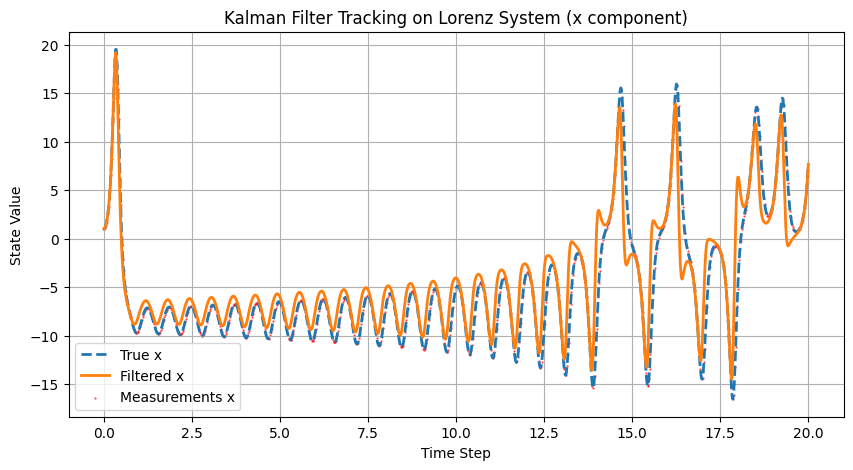

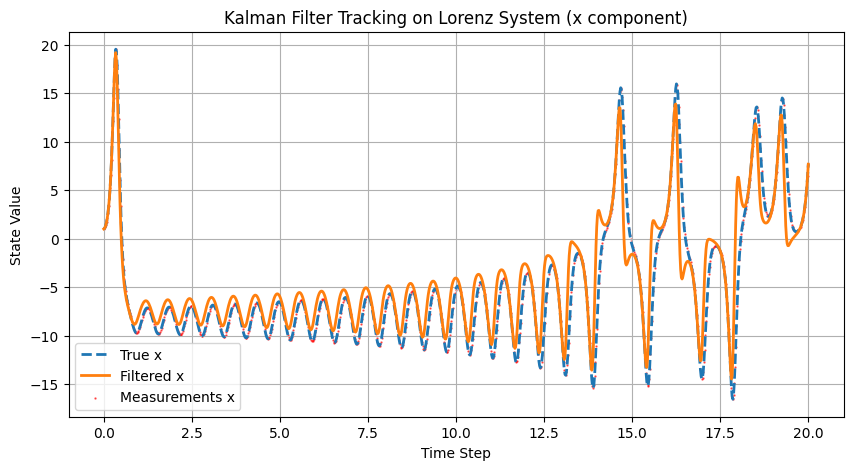

In [17]:
# Insert experiments for Q 3.2 here...
kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.2)
kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.05)
kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.001)
kalman_2(Q=np.eye(3) * 0.0 * dt, R = np.eye(2) * 0.0000001)

**Q 3.3:** Set the process noise small, then experiment with the relationship between the step size `dt` and the measurement noise needed to relaible inference. For example, try setting `dt = 0.1` and the measurement noise to `0.01`. Can you get away with larger measurement noise? Given coarse intervals, how fine must our measurements be? Comment on the feasibility of long term prediction in chaotic systems, and the balance between the uncertainty produced by the dynamic, and the information (reduction of uncertainty) produced by measurement.

Although the results are pretty consistently off for the peaks in the true state, irregardless of the measurement noise, we notice that larger time steps (dt) create much larger errors, while smaller time steps allow for much better convergence. It goes to show that frequent measurement to reduce uncertainty is the best way to model chaotic systems, as they have a tendency to change very fast.

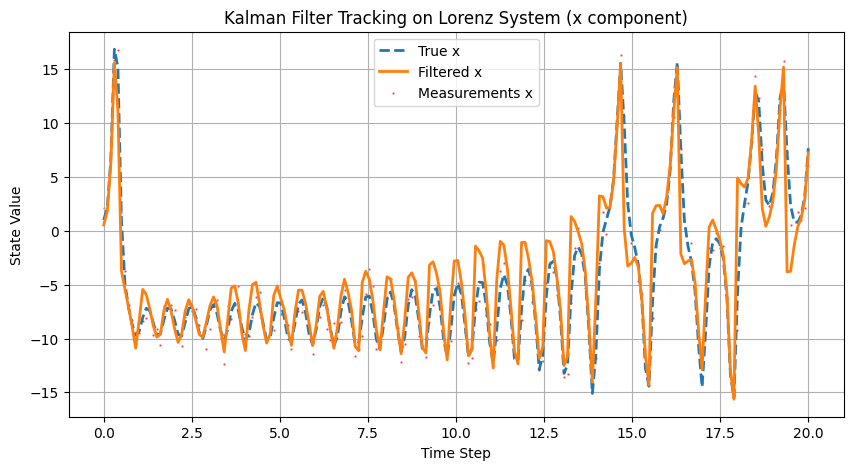

In [18]:
# Insert experiments for Q 3.3 here...

dt = 0.1
kalman_2(Q=np.eye(3) * 0.01 * dt, R = np.eye(2) * 1)

## Outro: A note on revolutions

As foreshadowed at the start of this lab, the Kalman filtering technique implemented above was the gold standard in many large data assimilation problems, particularly weather prediction, until this year. AI models trained on simulated weather data may now provide more skillful predictions (see [GraphCast, 2023](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) and [GenCast, Nature, 2025](https://www.nature.com/articles/s41586-024-08252-9)).

How is this possible?

A simple answer is that trying to predict the behavior of the weather far in advance requires running many simulations of the dynamical system, initialized from different possible current states. That is, initialized from the current posterior. Because the dyanmic is chaotic, these rapidly spread out. Think about dropping a ball into a Plinko board. If you could exactly specify its position and momentum at the start, and the material properties of the ball and pins, and how the board is stabilized on the table, and how the ball interacts with the air, and its rolling friction against the board, and the exact surface topology of the board, then, in principle, you could predict where it would go, after many bounces, with high precision. Of course, this is essentially impossible. The ball's final position behaves as if it were random since we don't have complete information on the dynamic, or on the starting condition. If you have a highly concentrated prior over the initial conditions, then you may be able to precisely predict the ball's location after one or two bounces. However, the farther you look into the future, the faster your posterior will spread out. 

Weather simulations have exactly the same problem. Like Plinko, they also follow regular statistical patterns over different time frames. For example, after many bounces, a ball descending a Plinko board will have a horizontal position that is roughly Gaussian distributed. If you haven't tried this, there are amazing demos (ask the instructor). So, while we may not be able to predict the exact motion of a particular ball, we could learn to approximate its distribution at any stage down the board, then use those distributions to model our uncertainty about the position of the ball. Moreover, since Plinko can be subdivided into many copies of the same problem, if we conditioned on an initial position for the ball, we could update our distributional estimate (e.g. our posterior) to reflect our observation.

In a Plinko board, you might imagine that the distribution produced by simulating the physics forward should mimic the physics closely enough that the simulated distribution would match the observed distribution over a long time frame. This is much harder for weather prediction. As a result, the simulated posterior looking far in advance may not capture long time statistical behavior of actual weather data. Alternately, since simulation is expensive, it may not sample finely enough.

In contrast, an AI model trained to imitate observed statistical patterns may sacrifice the step-by-step consistency of a physical simulation for the capacity to model observed long-time statistics. For long-term prediction in highly chaotic problems, this strategy can beat out direct simulation.